In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from macrohet import visualise, dataio, tile
from tqdm.auto import tqdm
import os
import btrack
import json
import napari
import matplotlib as mpl
import matplotlib.patches as patches
import pickle
import glob
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import subprocess
from scipy.interpolate import UnivariateSpline
import glob
scale_factor = 6048/1200

# Function to calculate gradient for a window
def calculate_gradient(window):
    y = window
    x = np.arange(len(window))
    slope, _ = np.polyfit(x, y, 1)
    return slope

def find_doubling_points(time_values, mtb_values, min_mtb_value):
    # Check if any value doubles within the series
    for i in range(len(mtb_values)):
        q1 = mtb_values[i]
        t1 = time_values[i]
        
        # Skip if the mtb value is below the minimum threshold
        if q1 < min_mtb_value:
            continue
        
        for j in range(i + 1, len(mtb_values)):
            q2 = mtb_values[j]
            t2 = time_values[j]
            
            # Check if q2 is at least double q1
            if q2 >= 2 * q1:
                return t1, t2, q1, q2
    return None, None, None, None  # If no doubling is found

def create_video_from_frames(input_folder, output_video, fps=5):
    # Ensure the input folder path ends with a slash
    if not input_folder.endswith('/'):
        input_folder += '/'

    # Check if there are any PNG files in the directory
    png_files = glob.glob(input_folder + '*_t_*.png')
    if not png_files:
        raise ValueError("No PNG files found in the specified directory")

    # FFmpeg command to create video
    command = [
    'ffmpeg',
    '-y', #overwrite video files without asking
    '-framerate', str(fps),
    '-pattern_type', 'glob',
    '-i', f'{input_folder}*_t_*.png',
    '-vf', 'pad=ceil(iw/2)*2:ceil(ih/2)*2',  # Adjust dimensions
    '-c:v', 'libx264',
    '-pix_fmt', 'yuv420p',
    output_video
    ]
    subprocess.run(command)

def create_rgb_image(glimpse_frame):
    # check if blank frame first by consulting the mask channel
    if np.all(glimpse_frame[0] == 0):
        rgb_image = np.zeros(glimpse_frame.shape[1:] + (3,))

        return rgb_image
    
    # Normalize each axis to range [0, 1]
    normalized = (glimpse_frame - np.min(glimpse_frame, axis=(1, 2), keepdims=True)) / \
                 (np.max(glimpse_frame, axis=(1, 2), keepdims=True) - np.min(glimpse_frame, axis=(1, 2), keepdims=True))

    # Create an empty RGB image
    rgb_image = np.zeros(normalized.shape[1:] + (3,))  # Shape (500, 500, 3)

    # Assigning the normalized channels to the corresponding RGB channels
    # Cyan: First axis (Green + Blue)
    rgb_image[..., 1] += normalized[0]  # Green channel
    rgb_image[..., 2] += normalized[0]  # Blue channel
    
    # Green: Second axis (Green)
    rgb_image[..., 1] += normalized[1]
    
    # Magenta: Third axis (Red + Blue)
    rgb_image[..., 0] += normalized[2]  # Red channel
    rgb_image[..., 2] += normalized[2]  # Blue channel
    
    # Clipping values to ensure they are within [0, 1]
    rgb_image = np.clip(rgb_image, 0, 1)

    return rgb_image

### Set style for plotting

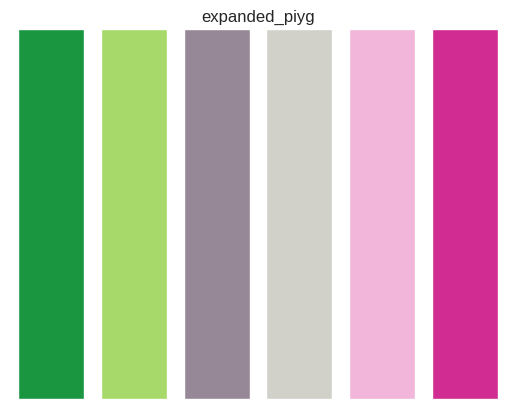

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [2]:
sns.set(style = 'white')

# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Liberation Sans'

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)

### Load sc df

In [3]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_GT_70_interp.pkl')
df['dMtb'] = df['delta Mtb max fold-change normalised max area']
df['Mtb'] = df['Intracellular thresholded Mtb content smooth']
# Assuming your DataFrame is named 'df'
df['Strain/Compound'] = df['Compound']  # Create a new column and copy values from 'Compound'
# Replace values in 'NewColumn' where 'Strain' is 'RD1' with 'RD1'
df.loc[df['Strain'] == 'RD1', 'Strain/Compound'] = 'RD1'
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Strain,Compound,Concentration,Technical replicate,Cell ID,Acquisition ID,Unique ID,dMtb,Mtb,Strain/Compound
0,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
1,1,459.138947,6.718642,2314.060291,33.861954,0.0,1.0,0.0,16683.0,344.687042,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
2,2,460.555237,10.785886,2321.198394,54.360864,0.0,1.0,0.0,18935.0,343.875061,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
3,3,455.878815,11.143067,2297.629226,56.161059,1.0,1.0,0.0,19937.0,345.565796,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
4,4,462.634186,14.050420,2331.676296,70.814116,1.0,1.0,0.0,21793.0,350.585083,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296992,70,628.562500,1099.782104,3167.955000,5542.901807,1.0,0.0,1.0,101991.0,377.731873,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.031497,BDQ
296993,71,628.463684,1102.144409,3167.456968,5554.807822,1.0,0.0,1.0,100978.0,377.812103,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.274554,BDQ
296994,72,628.672058,1101.594727,3168.507173,5552.037422,1.0,0.0,1.0,108397.0,376.812805,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.220153,BDQ
296995,73,630.372803,1102.817749,3177.078926,5558.201455,1.0,0.0,1.0,107079.0,377.437073,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.002094,BDQ


### Calculate the maximum gradient for each cell

In [4]:
# df['Max. dMtb gradient'] = np.nan  # Initialize with NaN instead of None
for unique_ID in tqdm(df['Unique ID'].unique()):
    sc_df = df[df['Unique ID'] == unique_ID]

    max_gradient = sc_df['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).max()
    df.loc[df['Unique ID'] == unique_ID, 'Max. dMtb gradient'] = max_gradient
    # if max_gradient > 120:
    #     print(unique_ID)

  0%|          | 0/3988 [00:00<?, ?it/s]

### Isolate the top ten fastest growers

In [5]:
N = 100
top_N_tracks = df.groupby('Unique ID')['Max. dMtb gradient'].max().sort_values(ascending=False).head(N)

In [6]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/PS0000/'
metadata_path = os.path.join(base_dir, 'Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
5   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

In [7]:
metadata_fn = os.path.join(base_dir, 'Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [8]:
tracks_dict = dict()
segmentation_dict = dict()

### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(f'/mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/{row,column}.h5', 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
        seg = reader.segmentation
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks
    segmentation_dict[(row, column)] = seg

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/11/28 10:46:49 AM] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
[INFO][2023/11/28 10:46:49 AM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2023/11/28 10:46:49 AM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2023/11/28 10:46:49 AM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/11/28 10:46:58 AM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/11/28 10:46:58 AM] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
[INFO][2023/11/28 10:46:58 AM] Opening HDF file: /mnt/DATA/macrohet/labels/P

In [9]:
# load previously calculated mtb areas to save on computation
with open('mtb_areas_dict.pkl', 'rb') as file:
    mtb_areas_dict = pickle.load(file)

In [10]:
len(mtb_areas_dict)

32

In [14]:
for i in mtb_areas_dict.keys():
    print(len(mtb_areas_dict[i]))
    print(i)

74
280.3.5
75
85.4.5
75
375.5.6
71
1092.6.5
75
381.5.5
71
264.4.6
71
11.4.5
74
671.3.8
75
118.4.5
71
707.5.4
73
377.4.9
71
985.3.8
73
105.3.5
75
376.5.5
74
327.4.5
73
304.5.5
74
301.4.5
75
531.5.5
75
161.5.6
75
587.5.7
75
624.5.5
71
486.3.5
73
795.4.5
75
506.5.5
75
352.3.5
73
254.4.5
75
130.6.5
75
131.4.9
74
492.6.5
75
625.6.5
157
577.5.5
157
289.3.5


In [15]:
del mtb_areas_dict['577.5.5']
del mtb_areas_dict['289.3.5']

In [16]:
image_dir = os.path.join(base_dir, 'Images')

In [86]:
physical_length_m = 10E-6
resolution_m_per_pixel = 1.47E-7
size = 500
min_mtb_area = 88
window = 4

Iterating over top growth outliers:   0%|          | 0/100 [00:00<?, ?it/s]

Loading pre generated glimpse


Creating mask glimpse ID: ((3, 5), 280):   0%|          | 0/74 [00:00<?, ?it/s]

Loading mtb areas


Saving out single frames:   0%|          | 0/74 [00:00<?, ?it/s]

/tmp/ipykernel_541202/2813950294.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(figsize=(10, 4))


KeyboardInterrupt: 

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

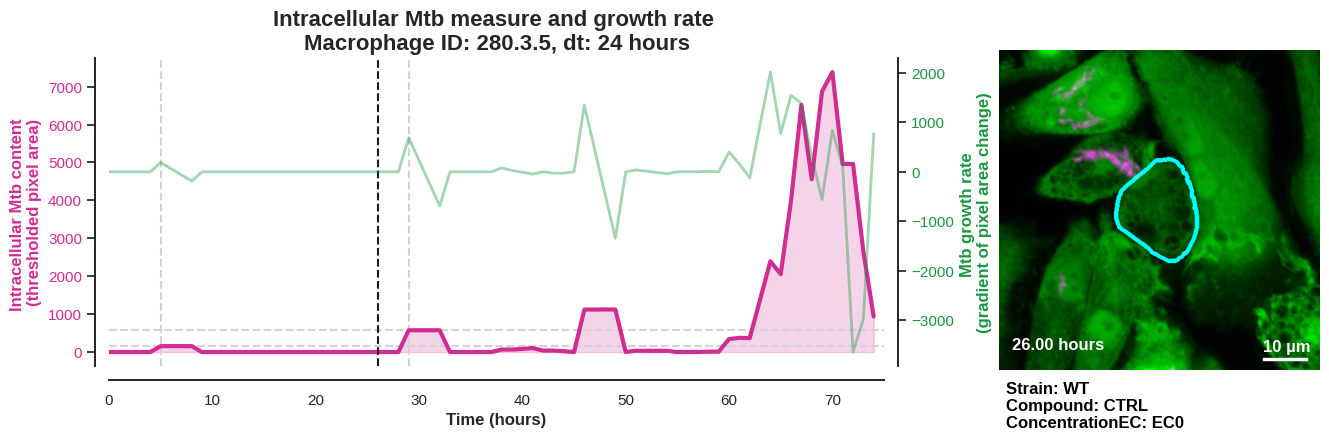

In [97]:
# Plot 'Mtb' and the calculated gradient against 'Time (hours)' for each of the top ten tracks
for n, track_id in tqdm(enumerate(top_N_tracks.keys()), total = len(top_N_tracks.keys()), desc = 'Iterating over top growth outliers'):
    # Extract rows corresponding to the current track
    track_data = df[df['Unique ID'] == track_id]
    
    # get acq ID and ID from track id'
    acq_ID = track_data['Acquisition ID'].iloc[0]
    cell_ID = track_data['Cell ID'].iloc[0]
    row, column = acq_ID
    
    # define output prior to checking if already created mp4 for this example 
    output_folder = f'/mnt/DATA/macrohet/results/glimpses/fast_grower_area_graph/{acq_ID}/{track_id}'
    if os.path.exists(f"{output_folder}/ID_{track_id}_outlying_growth_glimpse_graph.mp4"):
        continue
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    frame_output_folder = os.path.join(output_folder, 'frames')
    if not os.path.exists(frame_output_folder):
        os.makedirs(frame_output_folder)
        
    # pre load images
    images = tile.compile_mosaic(image_dir, 
                         metadata, 
                         row, column, 
                         set_plane='max_proj',
                        )

    # get glimpse if already created
    if track_id+'.npy' in os.listdir('./outliers'):
        print('Loading pre generated glimpse')
        glimpse = np.load(os.path.join(f'./outliers/{track_id}.npy'))
    # or generate
    else:
        print('Generating glimpse')
        glimpse = visualise.create_glimpse_from_sc_df(track_data, acq_ID, cell_ID, images).compute().compute()

    # get associated masks
    masks = segmentation_dict[acq_ID]
    mask_glimpse = visualise.create_mask_glimpse_from_sc_df(track_data, acq_ID, cell_ID, masks)
    mask_glimpse_expanded = np.expand_dims(mask_glimpse, axis=0)
    final_glimpse = np.concatenate((mask_glimpse_expanded, glimpse), axis = 0)

    # now check if mtb areas already calculated
    if track_id in mtb_areas_dict.keys():
        # load if already measured
        print('Loading mtb areas')
        mtb_areas = mtb_areas_dict[track_id]
    else:
        mtb_areas = []
        for df_row in tqdm(track_data.iterrows(), total=len(track_data),
                desc=f'Extracting mtb area over each frame: {acq_ID, cell_ID}'):
            # get coords
            t, y, x = df_row[1]['Time (hours)'], int(df_row[1]['y']), int(df_row[1]['x'])
            y, x = int(y*scale_factor), int(x*scale_factor)
            # select proper frame
            frame = masks[t, ...]
            # check to see if mask exists
            if frame[y, x]:
                # select cell of interest
                mask = frame == frame[y, x]
                # get mtb channel at set frame
                images = tile.compile_mosaic(image_dir, 
                                             metadata, 
                                             row, column, 
                                             set_plane='max_proj',
                                             set_channel=2,
                                             set_time=t
                                                )[0, 0]
                # only load the crop bounding box necessary
                rows = np.any(mask, axis=1)
                cols = np.any(mask, axis=0)
                # Bounding box's top and bottom
                ymin, ymax = np.where(rows)[0][[0, -1]]
                # Bounding box's left and right
                xmin, xmax = np.where(cols)[0][[0, -1]]
                # The bounding box is defined by the coordinates (xmin, ymin) and (xmax, ymax)
                bounding_box = (xmin, ymin, xmax, ymax)
                bounded_image = images[ymin:ymax+1, xmin:xmax+1].compute().compute()
                bounded_mask = mask[ymin:ymax+1, xmin:xmax+1]
                masked_image = bounded_image*bounded_mask 
                thresholded_masked_image = masked_image >=480
                mtb_area = np.sum(thresholded_masked_image)
                mtb_areas.append(mtb_area)
            else:
                mtb_areas.append(0)  # Append 0 if no mask exists
            
            mtb_areas_dict[track_id] = mtb_areas
            # Save the dictionary to a file
            with open('mtb_areas_dict.pkl', 'wb') as file:
                pickle.dump(mtb_areas_dict, file)
        
    # get varialbes to plot 
    time_values = track_data['Time (hours)'].values
    mtb_values = pd.Series(mtb_areas).rolling(window=window).mean().bfill().values #track_data['Mtb'].values
    gradient_values = pd.Series(mtb_areas).rolling(window=window).apply(calculate_gradient, raw=True).bfill().values #track_data['Mtb']
    scale_bar_length_pixels = int(physical_length_m / resolution_m_per_pixel)    
    
    for frame_index in tqdm(range(final_glimpse.shape[1]), desc = 'Saving out single frames'):
        fig, ax1 = plt.subplots(figsize=(10, 4))
        ax1.set_xlim(0,75)
        # plot doubling time
        t1, t2, q1, q2 = find_doubling_points(time_values, mtb_values, min_mtb_area)
        if t1 is not None and t2 is not None:
            # print(f"Found doubling from {q1} to {q2} between {t1} and {t2} hours")
            # Overlay doubling time lines and annotations
            for dt in [t1, t2]:
                ax1.axvline(x=dt, color='lightgrey', linestyle='--', linewidth = 1)
                # ax1.text(dt, max(mtb_area),)# f'{dt:.2f} h', rotation=45)
            for dt in [q1, q2]:
                ax1.axhline(y=dt, color='lightgrey', linestyle='--')
                # ax1.text(0, max(time_values),)# f'{dt:.2f} h', rotation=45)
            # add title 
            plt.title(f'Intracellular Mtb measure and growth rate \nMacrophage ID: {track_id}, dt: {t2-t1} hours', fontsize=16, fontweight='bold')
        else:
            print("No doubling found in the provided data.")
            # add title 
            plt.title(f'Intracellular Mtb measure and growth rate \nMacrophage ID: {track_id}', fontsize=16, fontweight='bold')
        
        # set axis labels
        ax1.set_xlabel('Time (hours)', fontweight='semibold')
        ax1.set_ylabel('Intracellular Mtb content \n(thresholded pixel area)', color=expanded_piyg[-1], fontweight='semibold')
        ax1.tick_params(axis='y', labelcolor=expanded_piyg[-1])

        # Fit and plot the mtb
        ax1.plot(time_values, mtb_values, label='Intracellular Mtb', color=expanded_piyg[-1], linewidth = 3)
        ax1.fill_between(time_values, 0, mtb_values, color=expanded_piyg[-1], alpha=0.2)  # Adjust alpha for transparency

        # Setup for the secondary axis
        ax2 = ax1.twinx()
        ax2.set_ylabel('Mtb growth rate \n(gradient of pixel area change)', color=expanded_piyg[0], fontweight='semibold')
        ax2.tick_params(axis='y', labelcolor=expanded_piyg[0])
        
        # Fit and plot the gradient_values
        ax2.plot(time_values, gradient_values, label='Gradient', color=expanded_piyg[0], alpha = 0.4, linewidth = 2)
        
        # Vertical line
        vline = ax1.axvline(x=time_values[frame_index], color='k', linestyle='--')
        
        # Add RGB image
        image_ax = fig.add_axes([0.90, 0.1, 0.55, 0.8])  # Adjust as needed
        rgb_image = create_rgb_image(final_glimpse[:, frame_index, ...])
        image_ax.imshow(rgb_image)
        image_ax.axis('off')
        
        # Position of the scale bar (bottom right corner)
        x_position = rgb_image.shape[1] - scale_bar_length_pixels - 20  # 20 pixels from the right edge
        y_position = rgb_image.shape[0] - 20  # 20 pixels from the bottom edge
        
        # Create a rectangle patch for the scale bar
        scale_bar = patches.Rectangle((x_position, y_position), scale_bar_length_pixels, 3, color='white')
        
        # Add the scale bar to the image
        image_ax.add_patch(scale_bar)
        
        # Optionally, add text to label the scale bar
        scale_bar_physical_length = "10 µm"
        plt.text(x_position, y_position - 10, scale_bar_physical_length, color='white', fontsize=12, fontweight='semibold')
        
        # Add a timestamp on the bottom left corner of the image
        timestamp_position_x = 20  # 20 pixels from the left edge
        timestamp_position_y = rgb_image.shape[0] - 32  # 20 pixels from the bottom edge
        timestamp_text = f"{time_values[frame_index]:.2f} hours"  # Format the time with 2 decimal places
        plt.text(timestamp_position_x, timestamp_position_y, timestamp_text, color='white', fontsize=12, transform=image_ax.transData, fontweight='semibold')
        
        # Retrieve the data for overlay text
        row_data = assay_layout.loc[acq_ID]  # Adjust the index as per your requirements
        strain = row_data['Strain']
        compound = row_data['Compound']
        concentration_ec = row_data['ConcentrationEC']
        
        # Overlay text on the image
        overlay_text = f"Strain: {strain}\nCompound: {compound}\nConcentrationEC: {concentration_ec}"
        image_ax.text(10, size+90, overlay_text, color='black', fontsize=12, transform=image_ax.transData, fontweight='semibold')
        
        sns.despine(offset = 10, right = False)
        
        # Save each frame plot
        zfill_time = f'{time_values[frame_index]}'.zfill(len(str(time_values.max())))
        plt.savefig(f"{output_folder}/frames/ID_{track_id}_dt_{t2-t1}_t_{zfill_time}.png", bbox_inches = 'tight', dpi = 314)
        # plt.show()
        plt.clf()

    # Create mp4 video
    create_video_from_frames(f"{output_folder}/frames/", f"{output_folder}/ID_{track_id}_dt_{t2-t1}_outlying_growth_glimpse_graph.mp4", fps=5)